### **NIHCC Dataset Distribution**

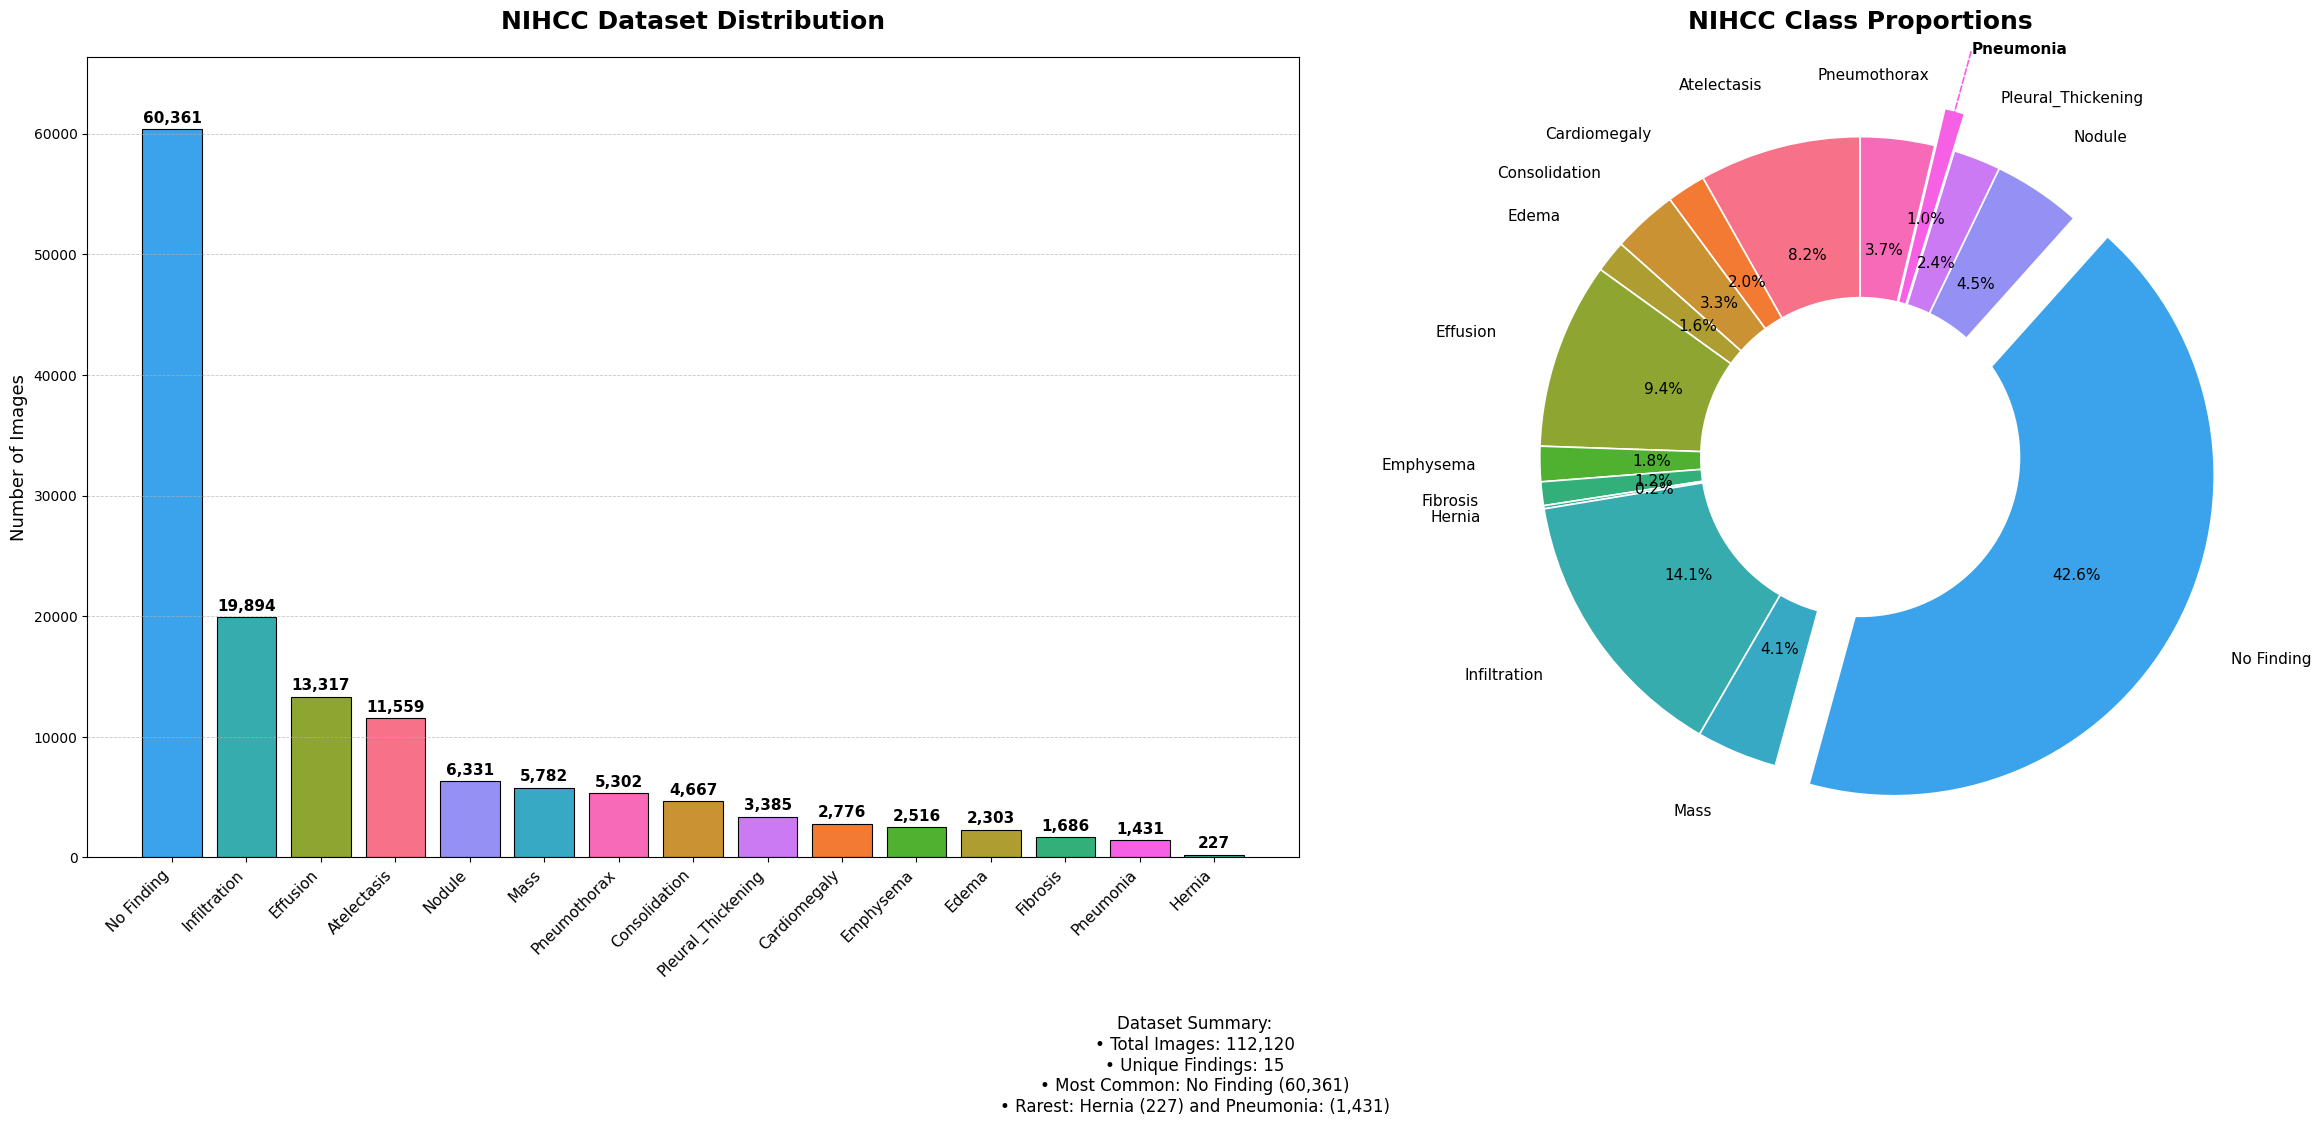

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# ─────────────────────────────────────────────────────────────────────────────
# Adjust this path if needed so it matches where your CSV is in Colab:
csv_path = "/content/drive/MyDrive/NIH_ChestXray/Data_Entry_2017_v2020.csv"
# ─────────────────────────────────────────────────────────────────────────────

# 1) Read the CSV
df = pd.read_csv(csv_path)

# 2) Extract all unique labels (alphabetical) from “Finding Labels”
all_labels = sorted({
    lab.strip()
    for row in df["Finding Labels"]
    for lab in row.split("|")
})

# 3) Count how many rows contain each label
counts = [int(df["Finding Labels"].str.contains(lbl).sum()) for lbl in all_labels]

# 4) Create a color map so each label has a fixed, truly unique color
#    Using seaborn “husl” palette for 15 distinct, easily distinguishable colors
palette = sns.color_palette("husl", len(all_labels))
color_map = dict(zip(all_labels, palette))

# 5) Prepare sorted lists for the bar chart only (descending by count)
label_count_pairs = sorted(
    zip(all_labels, counts),
    key=lambda x: x[1],
    reverse=True
)
sorted_labels, sorted_counts = zip(*label_count_pairs)

# 6) Create side-by-side subplots
fig, (ax_bar, ax_pie) = plt.subplots(
    1,
    2,
    figsize=(24, 10),
    gridspec_kw={"width_ratios": [1.3, 1]},
)

# ─────────────────────────────────────────────────────────────────────────────
# 7) BAR CHART on ax_bar (descending order, colors from color_map)
plt.style.use("ggplot")

bar_colors = [color_map[label] for label in sorted_labels]
x_pos = range(len(sorted_labels))
bars = ax_bar.bar(x_pos, sorted_counts, color=bar_colors, edgecolor="black", linewidth=0.8)

# Annotate each bar with its raw count (bold, slightly above)
for bar, cnt in zip(bars, sorted_counts):
    h = bar.get_height()
    ax_bar.text(
        bar.get_x() + bar.get_width() / 2,
        h + max(sorted_counts) * 0.005,
        f"{cnt:,}",
        ha="center",
        va="bottom",
        fontsize=11,
        fontweight="bold",
    )

ax_bar.set_xticks(x_pos)
ax_bar.set_xticklabels(sorted_labels, rotation=45, ha="right", fontsize=11)
ax_bar.set_ylabel("Number of Images", fontsize=13)
ax_bar.set_title("NIHCC Dataset Distribution", fontsize=18, fontweight="bold", pad=20)
ax_bar.set_ylim(0, max(sorted_counts) * 1.10)
ax_bar.yaxis.grid(True, linestyle="--", linewidth=0.6, alpha=0.7)
ax_bar.xaxis.grid(False)

# ─────────────────────────────────────────────────────────────────────────────
# 8) PIE CHART on ax_pie (alphabetical order, using same color_map)
explode = [0.0] * len(all_labels)
explode[all_labels.index("Pneumonia")] = 0.12
explode[all_labels.index("No Finding")] = 0.12

pie_colors = [color_map[label] for label in all_labels]
wedges, texts, autotexts = ax_pie.pie(
    counts,
    labels=all_labels,
    autopct="%1.1f%%",
    startangle=90,
    pctdistance=0.65,
    labeldistance=1.2,
    explode=explode,
    colors=pie_colors,
    wedgeprops={"edgecolor": "white", "linewidth": 1.2},
    textprops={"fontsize": 11},
)

ax_pie.set_title("NIHCC Class Proportions", fontsize=18, fontweight="bold", pad=20)
centre_circle = plt.Circle((0, 0), 0.50, fc="white")
ax_pie.add_artist(centre_circle)

# 9) Bold only “Pneumonia” label at its default position
idx_pneum = all_labels.index("Pneumonia")
texts[idx_pneum].set_fontweight("bold")

# 10) Draw a straight dashed line from the Pneumonia wedge to its bold label
mid_angle_pn = (wedges[idx_pneum].theta1 + wedges[idx_pneum].theta2) / 2
angle_rad_pn = np.deg2rad(mid_angle_pn)
x_w_pn, y_w_pn = np.cos(angle_rad_pn) * 0.7, np.sin(angle_rad_pn) * 0.7

x_label_pn, y_label_pn = texts[idx_pneum].get_position()
ax_pie.annotate(
    "",
    xy=(x_w_pn, y_w_pn),
    xytext=(x_label_pn, y_label_pn),
    arrowprops={
        "arrowstyle": "-",
        "linestyle": "--",
        "color": color_map["Pneumonia"],
        "linewidth": 1.2,
        "connectionstyle": "arc3,rad=0"
    },
)

# 11) Shift “Pneumothorax” label left (normal weight) so it sits over its wedge
idx_ptx = all_labels.index("Pneumothorax")
mid_angle_ptx = (wedges[idx_ptx].theta1 + wedges[idx_ptx].theta2) / 2
angle_rad_ptx = np.deg2rad(mid_angle_ptx)
r_ptx_label = 1.2
x_w_ptx, y_w_ptx = np.cos(angle_rad_ptx) * r_ptx_label, np.sin(angle_rad_ptx) * r_ptx_label

# Remove default Pneumothorax text, then add a new one in black
texts[idx_ptx].set_text("")
ax_pie.text(
    x_w_ptx - 0.1,
    y_w_ptx,
    "Pneumothorax",
    ha="center",
    va="center",
    fontsize=11,
    fontweight="normal",
    color="black",
)

# ─────────────────────────────────────────────────────────────────────────────
# 12) Add summary statistics beneath the combined figure
# Compute summary:
total_images = len(df)
unique_findings = len(all_labels)
label_counts = pd.Series(counts, index=all_labels).sort_values(ascending=False)

most_common = label_counts.index[0]
most_common_count = label_counts.values[0]
rarest = label_counts.index[-1]
rarest_count = label_counts.values[-1]
rarest1 = label_counts.index[-2]
rarest_count1 = label_counts.values[-2]

summary_text = (
    "Dataset Summary:\n"
    f"• Total Images: {total_images:,}\n"
    f"• Unique Findings: {unique_findings}\n"
    f"• Most Common: {most_common} ({most_common_count:,})\n"
    f"• Rarest: {rarest} ({rarest_count:,}) and {rarest1}: ({rarest_count1:,})"
)

# Place summary text centered below both subplots
fig.text(
    0.5, -0.02, summary_text,
    ha="center", va="top", fontsize=12
)

plt.tight_layout()
plt.show()

In [ ]:
# Paths
csv_path = "/content/drive/MyDrive/NIH_ChestXray/pneumonia_vs_normal_unbalanced.csv"
image_dir = "/content/drive/MyDrive/NIH_ChestXray/images_extracted/images"


# Load and prepare dataset
print("Loading dataset...")
df = pd.read_csv(csv_path)
print("Original dataset size:", len(df))

# Create proper binary labels
df['class'] = df['Finding Labels'].apply(lambda x: 'pneumonia' if 'pneumonia' in x.lower() else 'normal')

# Map filenames to full paths
df['filepath'] = df['Image Index'].apply(lambda x: os.path.join(image_dir, x))

# Verify files exist
df = df[df['filepath'].apply(os.path.exists)]
print("Dataset size after verification:", len(df))

# Compute class counts
class_counts = df['class'].value_counts()
print("\nClass distribution:")
print(class_counts)

Loading dataset...
Original dataset size: 61792
Dataset size after verification: 61788

Class distribution:
class
normal       60357
pneumonia     1431
Name: count, dtype: int64


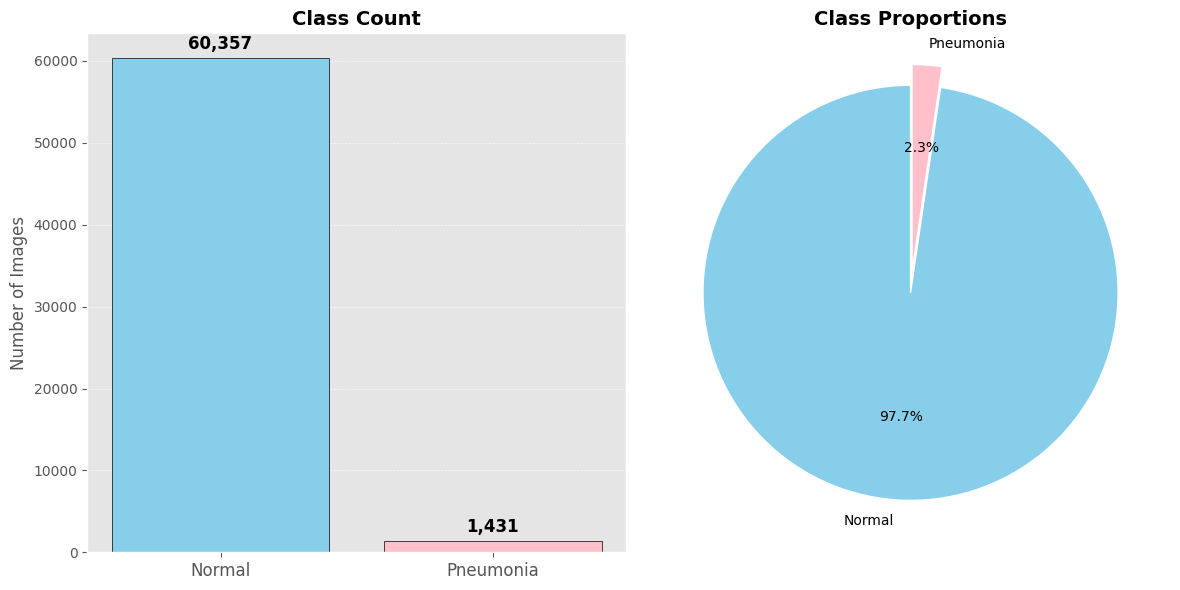

In [ ]:
# Visualization: side-by-side bar & pie

# Define labels and counts in consistent order
labels = ['normal', 'pneumonia']
counts = [class_counts.get('normal', 0), class_counts.get('pneumonia', 0)]

# Color mapping
color_map = {'normal': 'skyblue', 'pneumonia': 'pink'}
bar_colors = [color_map[label] for label in labels]
pie_colors = [color_map[label] for label in labels]

# Create subplots
fig, (ax_bar, ax_pie) = plt.subplots(1, 2, figsize=(12, 6))

# 1) BAR CHART with count annotations
x_pos = range(len(labels))
bars = ax_bar.bar(x_pos, counts, color=bar_colors, edgecolor="black")

for bar, cnt in zip(bars, counts):
    height = bar.get_height()
    ax_bar.text(
        bar.get_x() + bar.get_width() / 2,
        height + max(counts) * 0.01,
        f"{cnt:,}",
        ha="center",
        va="bottom",
        fontsize=12,
        fontweight="bold"
    )

ax_bar.set_xticks(x_pos)
ax_bar.set_xticklabels([lbl.capitalize() for lbl in labels], fontsize=12)
ax_bar.set_ylabel("Number of Images", fontsize=12)
ax_bar.set_title("Class Count", fontsize=14, fontweight="bold")
ax_bar.yaxis.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)
ax_bar.xaxis.grid(False)

# 2) PIE CHART with percentage annotations and explode pneumonia
explode = [0.0, 0.1]  # explode only the pneumonia slice
ax_pie.pie(
    counts,
    labels=[lbl.capitalize() for lbl in labels],
    autopct="%1.1f%%",
    startangle=90,
    colors=pie_colors,
    explode=explode,
    wedgeprops={"edgecolor": "white", "linewidth": 1}
)
ax_pie.set_title("Class Proportions", fontsize=14, fontweight="bold")

plt.tight_layout()
plt.show()

## **MOBILE_NET_V2 NIH CODE**

### **Import Libraries & Load Data**

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# NIH Dataset paths
train_dir = "/content/drive/MyDrive/NIH_processed/train"
test_dir = "/content/drive/MyDrive/NIH_processed/test"

# Check class imbalance in the NIH dataset
def check_class_imbalance(directory):
    """Check class distribution in the dataset"""
    print(f"Checking class distribution in: {directory}")
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            count = len([f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
            print(f"  {class_name}: {count} images")
    print()

# Check class imbalance
print("NIH Dataset Class Distribution:")
check_class_imbalance(train_dir)
check_class_imbalance(test_dir)

NIH Dataset Class Distribution:
Checking class distribution in: /content/drive/MyDrive/NIH_processed/train
  normal: 4069 images
  pneumonia: 1251 images

Checking class distribution in: /content/drive/MyDrive/NIH_processed/test
  normal: 1272 images
  pneumonia: 512 images



In [ ]:
# Image data parameters
img_height, img_width = 224, 224
batch_size = 32
seed = 123

# Data generators with augmentation for training
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # Using 20% for validation
)

val_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

# Create generators from directory structure
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True,
    seed=seed,
    subset='training'
)

val_generator = val_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False,
    seed=seed,
    subset='validation'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

Found 4257 images belonging to 2 classes.
Found 1063 images belonging to 2 classes.
Found 1784 images belonging to 2 classes.


#### **Build Model**

In [ ]:
# Build the MobileNetV2 model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
base_model.trainable = False  # Freeze the base model

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,586,177 (9.87 MB)

 Trainable params: 328,193 (1.25 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
# Calculate class weights to handle imbalance
from sklearn.utils import class_weight

# Get class labels from the training generator
class_labels = train_generator.classes

# Calculate class weights
class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(class_labels),
    y=class_labels
)

# Convert to a dictionary format required by model.fit
class_weight_dict = dict(enumerate(class_weights))

print("Calculated Class Weights:")
print(class_weight_dict)

Calculated Class Weights:
{0: np.float64(0.6537162162162162), 1: np.float64(2.1263736263736264)}


#### **Train Model**

In [ ]:
# Train the model (20 epochs) and record training time
from tensorflow.keras.callbacks import ModelCheckpoint
import time

best_model_path = "/content/drive/MyDrive/NIH_ChestXray/MobileNetv2_Best.h5"
model_checkpoint = ModelCheckpoint(
    filepath=best_model_path,
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

epochs = 20
start_time = time.time()
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // batch_size,
    epochs=epochs,
    callbacks=[model_checkpoint],
    class_weight=class_weight_dict # Add class weights here
)
end_time = time.time()
print(f"Total training time: {(end_time - start_time)/60:.2f} minutes")

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.6197 - loss: 0.6985
Epoch 1: val_loss improved from inf to 0.60659, saving model to /content/drive/MyDrive/NIH_ChestXray/MobileNetv2_Best.h5


133/133 ━━━━━━━━━━━━━━━━━━━━ 824s 6s/step - accuracy: 0.6198 - loss: 0.6981 - val_accuracy: 0.6780 - val_loss: 0.6066
Epoch 2/20
  1/133 ━━━━━━━━━━━━━━━━━━━━ 34s 260ms/step - accuracy: 0.6562 - loss: 0.6691

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_loss improved from 0.60659 to 0.60495, saving model to /content/drive/MyDrive/NIH_ChestXray/MobileNetv2_Best.h5


133/133 ━━━━━━━━━━━━━━━━━━━━ 25s 184ms/step - accuracy: 0.6562 - loss: 0.6691 - val_accuracy: 0.6809 - val_loss: 0.6050
Epoch 3/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 817ms/step - accuracy: 0.6863 - loss: 0.6052
Epoch 3: val_loss did not improve from 0.60495
133/133 ━━━━━━━━━━━━━━━━━━━━ 129s 968ms/step - accuracy: 0.6863 - loss: 0.6052 - val_accuracy: 0.6231 - val_loss: 0.6755
Epoch 4/20
  1/133 ━━━━━━━━━━━━━━━━━━━━ 36s 277ms/step - accuracy: 0.6875 - loss: 0.5315
Epoch 4: val_loss did not improve from 0.60495
133/133 ━━━━━━━━━━━━━━━━━━━━ 20s 150ms/step - accuracy: 0.6875 - loss: 0.5315 - val_accuracy: 0.6212 - val_loss: 0.6748
Epoch 5/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 815ms/step - accuracy: 0.6673 - loss: 0.5970
Epoch 5: val_loss did not improve from 0.60495
133/133 ━━━━━━━━━━━━━━━━━━━━ 128s 965ms/step - accuracy: 0.6673 - loss: 0.5971 - val_accuracy: 0.6799 - val_loss: 0.6143
Epoch 6/20
  1/133 ━━━━━━━━━━━━━━━━━━━━ 38s 291ms/step - accuracy: 0.7188 - loss: 0.4125
Epoch 6: val_loss did n

133/133 ━━━━━━━━━━━━━━━━━━━━ 130s 978ms/step - accuracy: 0.6894 - loss: 0.5921 - val_accuracy: 0.6932 - val_loss: 0.5946
Epoch 12/20
  1/133 ━━━━━━━━━━━━━━━━━━━━ 40s 306ms/step - accuracy: 0.6250 - loss: 0.5258
Epoch 12: val_loss did not improve from 0.59463
133/133 ━━━━━━━━━━━━━━━━━━━━ 20s 150ms/step - accuracy: 0.6250 - loss: 0.5258 - val_accuracy: 0.6837 - val_loss: 0.5965
Epoch 13/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 813ms/step - accuracy: 0.7113 - loss: 0.5791
Epoch 13: val_loss improved from 0.59463 to 0.58313, saving model to /content/drive/MyDrive/NIH_ChestXray/MobileNetv2_Best.h5


133/133 ━━━━━━━━━━━━━━━━━━━━ 129s 972ms/step - accuracy: 0.7113 - loss: 0.5791 - val_accuracy: 0.7462 - val_loss: 0.5831
Epoch 14/20
  1/133 ━━━━━━━━━━━━━━━━━━━━ 36s 279ms/step - accuracy: 0.6250 - loss: 0.6705
Epoch 14: val_loss improved from 0.58313 to 0.58055, saving model to /content/drive/MyDrive/NIH_ChestXray/MobileNetv2_Best.h5


133/133 ━━━━━━━━━━━━━━━━━━━━ 21s 159ms/step - accuracy: 0.6250 - loss: 0.6705 - val_accuracy: 0.7519 - val_loss: 0.5806
Epoch 15/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 814ms/step - accuracy: 0.7202 - loss: 0.5699
Epoch 15: val_loss improved from 0.58055 to 0.56542, saving model to /content/drive/MyDrive/NIH_ChestXray/MobileNetv2_Best.h5


133/133 ━━━━━━━━━━━━━━━━━━━━ 130s 975ms/step - accuracy: 0.7201 - loss: 0.5700 - val_accuracy: 0.7330 - val_loss: 0.5654
Epoch 16/20
  1/133 ━━━━━━━━━━━━━━━━━━━━ 40s 308ms/step - accuracy: 0.7188 - loss: 0.5395
Epoch 16: val_loss did not improve from 0.56542
133/133 ━━━━━━━━━━━━━━━━━━━━ 40s 298ms/step - accuracy: 0.7188 - loss: 0.5395 - val_accuracy: 0.7320 - val_loss: 0.5660
Epoch 17/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 818ms/step - accuracy: 0.7179 - loss: 0.5770
Epoch 17: val_loss did not improve from 0.56542
133/133 ━━━━━━━━━━━━━━━━━━━━ 129s 968ms/step - accuracy: 0.7179 - loss: 0.5771 - val_accuracy: 0.6600 - val_loss: 0.6280
Epoch 18/20
  1/133 ━━━━━━━━━━━━━━━━━━━━ 34s 265ms/step - accuracy: 0.6250 - loss: 0.6054
Epoch 18: val_loss did not improve from 0.56542
133/133 ━━━━━━━━━━━━━━━━━━━━ 20s 151ms/step - accuracy: 0.6250 - loss: 0.6054 - val_accuracy: 0.6553 - val_loss: 0.6357
Epoch 19/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 814ms/step - accuracy: 0.7023 - loss: 0.5862
Epoch 19: val_lo

#### **Plot History**

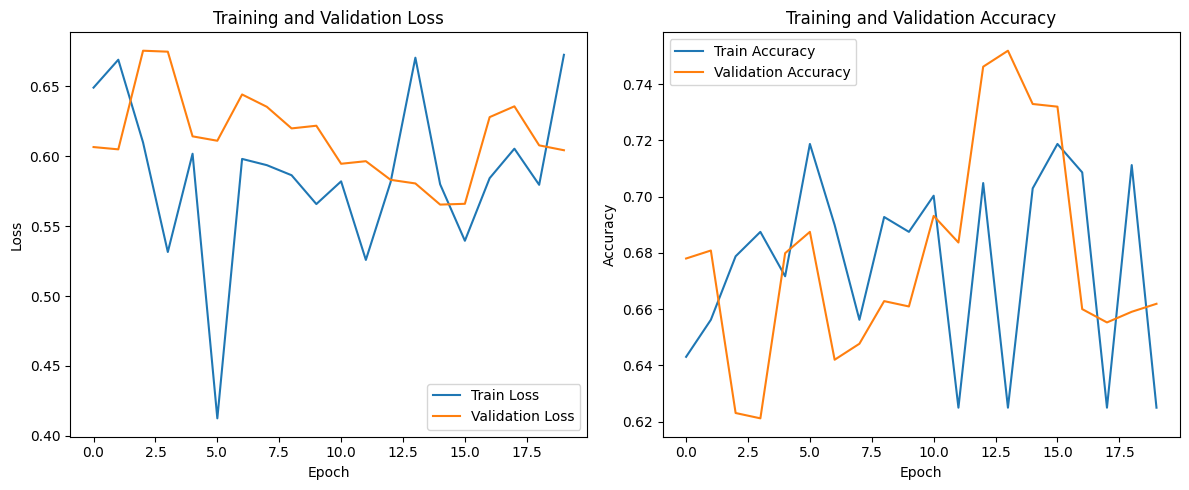

In [ ]:
# Plot training history
plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# best model path
best_model_path = "/content/drive/MyDrive/NIH_ChestXray/MobileNetv2_Best.h5"

### **Evaluation**

56/56 ━━━━━━━━━━━━━━━━━━━━ 939s 17s/step - accuracy: 0.7721 - loss: 0.5419

Test Loss: 0.5559
Test Accuracy: 0.7405
56/56 ━━━━━━━━━━━━━━━━━━━━ 34s 596ms/step

Classification Report:
              precision    recall  f1-score   support

      normal     0.8443    0.7799    0.8108      1272
   pneumonia     0.5402    0.6426    0.5870       512

    accuracy                         0.7405      1784
   macro avg     0.6922    0.7112    0.6989      1784
weighted avg     0.7570    0.7405    0.7466      1784



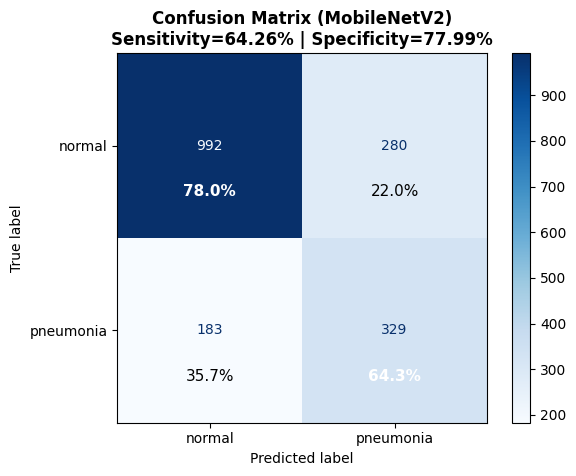

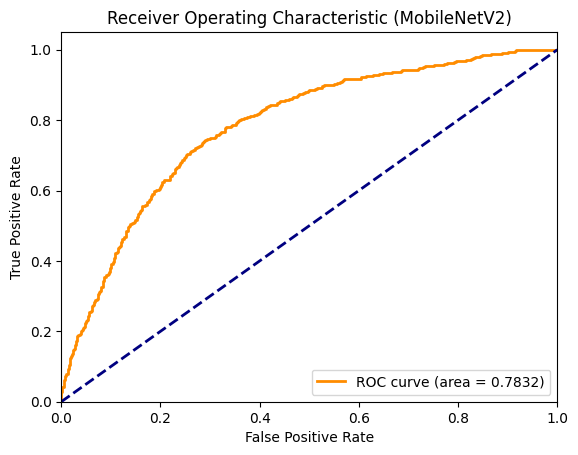


AUROC: 0.7832
Sensitivity: 0.6426
Specificity: 0.7799


In [ ]:
from tensorflow.keras.models import load_model
import math

best_model_path = "/content/drive/MyDrive/NIH_ChestXray/MobileNetv2_Best.h5"
# Load the best saved model for evaluation
model = load_model(best_model_path)

# Evaluate on test set
test_loss, test_acc = model.evaluate(test_generator)
print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

# Generate predictions
test_steps = math.ceil(test_generator.samples / batch_size)
y_pred_prob = model.predict(test_generator, steps=test_steps)
y_pred = (y_pred_prob > 0.50).astype(int).ravel()

# Get true labels from generator
y_true = test_generator.classes

# Classification report with 4 significant figures
print("\nClassification Report:")
print(classification_report(y_true, y_pred, digits=4, target_names=['normal', 'pneumonia']))

# Confusion Matrix with Plotting
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['normal', 'pneumonia'])
ax = disp.plot(cmap='Blues').ax_

# Calculate ROW-WISE percentages
row_totals = cm.sum(axis=1)
cm_percent = (cm.astype('float') / row_totals[:, np.newaxis]) * 100

# Add percent annotations with color matching
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        # Determine if this is a correct prediction (diagonal) or incorrect
        is_correct = (i == j)

        # Position and color settings
        ax.text(
            j,
            i + 0.25,  # Shift percentage below count
            f"{cm_percent[i, j]:.1f}%",
            ha='center',
            va='center',
            color='white' if is_correct else 'black',  # White for correct, black for errors
            fontsize=11,
            weight='bold' if is_correct else 'normal'
        )

# Calculate clinical metrics
sensitivity = cm[1,1]/row_totals[1]*100
specificity = cm[0,0]/row_totals[0]*100

plt.title(f"Confusion Matrix (MobileNetV2)\nSensitivity={sensitivity:.2f}% | Specificity={specificity:.2f}%", weight='bold')
plt.show()

# AUROC Curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (MobileNetV2)')
plt.legend(loc="lower right")
plt.show()

# Print AUROC, Sensitivity and Specificity
print(f"\nAUROC: {roc_auc:.4f}")

tn, fp, fn, tp = cm.ravel()
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
print(f"Sensitivity: {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")

#### **Evaluation (Enhanced Visual)**

56/56 ━━━━━━━━━━━━━━━━━━━━ 785s 14s/step - accuracy: 0.7721 - loss: 0.5419

Test Loss: 0.5559
Test Accuracy: 0.7405
56/56 ━━━━━━━━━━━━━━━━━━━━ 131s 2s/step

Classification Report:
              precision    recall  f1-score   support

      normal     0.8443    0.7799    0.8108      1272
   pneumonia     0.5402    0.6426    0.5870       512

    accuracy                         0.7405      1784
   macro avg     0.6922    0.7112    0.6989      1784
weighted avg     0.7570    0.7405    0.7466      1784



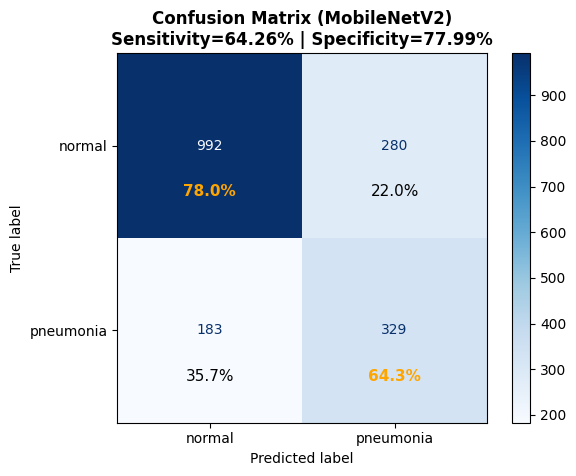

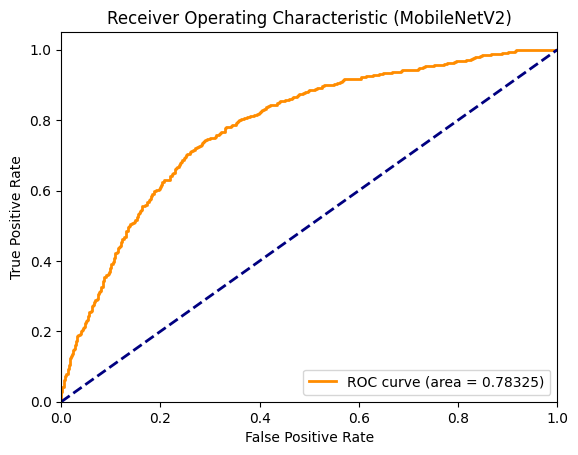


AUROC: 0.7832
Sensitivity: 0.6426
Specificity: 0.7799


In [ ]:
from tensorflow.keras.models import load_model
import math

best_model_path = "/content/drive/MyDrive/NIH_ChestXray/MobileNetv2_Best.h5"
# Load the best saved model for evaluation
model = load_model(best_model_path)

# Evaluate on test set
test_loss, test_acc = model.evaluate(test_generator)
print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

# Generate predictions
test_steps = math.ceil(test_generator.samples / batch_size)
y_pred_prob = model.predict(test_generator, steps=test_steps)
y_pred = (y_pred_prob > 0.50).astype(int).ravel()

# Get true labels from generator
y_true = test_generator.classes

# Classification report with 4 significant figures
print("\nClassification Report:")
print(classification_report(y_true, y_pred, digits=4, target_names=['normal', 'pneumonia']))

# Confusion Matrix with Plotting
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['normal', 'pneumonia'])
ax = disp.plot(cmap='Blues').ax_

# Calculate ROW-WISE percentages
row_totals = cm.sum(axis=1)
cm_percent = (cm.astype('float') / row_totals[:, np.newaxis]) * 100

# Add percent annotations with color matching
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        # Determine if this is a correct prediction (diagonal) or incorrect
        is_correct = (i == j)

        # Position and color settings
        ax.text(
            j,
            i + 0.25,  # Shift percentage below count
            f"{cm_percent[i, j]:.1f}%",
            ha='center',
            va='center',
            color='orange' if is_correct else 'black',
            fontsize=11,
            weight='bold' if is_correct else 'normal'
        )

# Calculate clinical metrics
sensitivity = cm[1,1]/row_totals[1]*100
specificity = cm[0,0]/row_totals[0]*100

plt.title(f"Confusion Matrix (MobileNetV2)\nSensitivity={sensitivity:.2f}% | Specificity={specificity:.2f}%", weight='bold')
plt.show()

# AUROC Curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.5f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (MobileNetV2)')
plt.legend(loc="lower right")
plt.show()

# Print AUROC, Sensitivity and Specificity
print(f"\nAUROC: {roc_auc:.4f}")

tn, fp, fn, tp = cm.ravel()
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
print(f"Sensitivity: {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")

#### **Model Size**

In [ ]:
# Load pre-trained MobileNetV2 model
model_path = "/content/drive/MyDrive/NIH_ChestXray/MobileNetv2_Best.h5"
model = load_model(model_path)
model_size_mb = os.path.getsize(model_path) / (1024 ** 2)
print(f"Model size: {model_size_mb:.2f} MB")

Model size: 11.01 MB


#### **Optional: Deployment Metrics**

In [ ]:
import os
import time
import numpy as np
import psutil
import threading
import gc
from tensorflow.keras.models import load_model


# 1. CPU Simulation and Model Loading
# Configure environment for CPU-only operation
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
import tensorflow as tf
tf.config.set_visible_devices([], 'GPU')

# Load pre-trained MobileNetV2 model
model_path = "/content/drive/MyDrive/NIH_ChestXray/MobileNetv2_Best.h5"
model = load_model(model_path)
model_size_mb = os.path.getsize(model_path) / (1024 ** 2)
print(f"Model size: {model_size_mb:.2f} MB")


# 2. System Hardware Specifications
cpu_freq = psutil.cpu_freq().current
cpu_cores_phys = psutil.cpu_count(logical=False)
cpu_cores_log = psutil.cpu_count(logical=True)
total_ram_gb = psutil.virtual_memory().total / (1024 ** 3)
print(f"CPU: {cpu_freq:.0f} MHz, {cpu_cores_phys}p/{cpu_cores_log}l cores")
print(f"Total RAM: {total_ram_gb:.2f} GB")


# 3. Memory Utilization Analysis
process = psutil.Process(os.getpid())

# Measure memory after model loading
ram_after_load_mb = process.memory_info().rss / (1024 ** 2)
print(f"RAM after load (RSS): {ram_after_load_mb:.1f} MB")

# Prepare test image from MobileNetV2 test generator
test_generator.reset()
test_images, _ = next(test_generator)
sample_image = test_images[0:1]

# Stabilize memory before measurement
_ = model.predict(sample_image, verbose=0)
gc.collect()

# Capture memory usage during inference
ram_before = process.memory_info().rss
_ = model.predict(sample_image, verbose=0)
ram_after = process.memory_info().rss

# Calculate peak and operational memory
ram_peak_mb = max(ram_before, ram_after) / (1024 ** 2)
ram_used_mb = ram_peak_mb - ram_after_load_mb
print(f"Peak RAM during inference: {ram_peak_mb:.1f} MB")
print(f"RAM used by inference: {ram_used_mb:.1f} MB")


# 4. Inference Time Performance

# Prepare 50 test images for timing analysis
test_generator.reset()
test_images, _ = next(test_generator)  # Get one batch of images from the generator
num_images = 50
test_samples = test_images[:num_images]  # Take up to 50 images from the batch

# Initial warm-up for consistent timing
_ = model.predict(test_samples[0:1], verbose=0)

# Measure inference latency across multiple samples
times_ms = []
start = time.perf_counter()
_ = model.predict(test_samples, verbose=0)
end = time.perf_counter()
# Calculate time per image
time_per_image_ms = (end - start) * 1000 / num_images
times_ms.append(time_per_image_ms)

# Calculate statistical performance
mean_inf_ms = np.mean(times_ms)
std_inf_ms = np.std(times_ms) if len(times_ms) > 1 else 0
print(f"Inference time ({num_images} images): {mean_inf_ms:.2f} ± {std_inf_ms:.2f} ms (per image)")


# 5. CPU Utilization and Power Estimation

cpu_samples = []
stop_sampling = False

def monitor_cpu(interval=0.05):
    """Background process to track CPU usage"""
    while not stop_sampling:
        cpu_samples.append(psutil.cpu_percent(interval=interval))

# Start CPU monitoring thread
monitor_thread = threading.Thread(target=monitor_cpu)
monitor_thread.daemon = True
monitor_thread.start()

# Perform inference while monitoring CPU
test_img = test_samples[0:1]
start_wall = time.perf_counter()
_ = model.predict(test_img, verbose=0)
end_wall = time.perf_counter()

# Finalize monitoring
stop_sampling = True
monitor_thread.join(timeout=1.0)

# Calculate power consumption estimate
avg_cpu = np.mean(cpu_samples) if cpu_samples else 0
est_power_w = (avg_cpu / 100) * 5  # Raspberry Pi power model
print(f"CPU utilization: {avg_cpu:.1f}%")


# 6. Clinical Deployment Assessment
print("\n" + "="*50)
print(f"{' MOBILENETV2 CLINICAL DEPLOYMENT METRICS ':.^50}")
print("="*50)
print(f"Model size: {model_size_mb:.2f} MB")
print(f"RAM after load (RSS): {ram_after_load_mb:.1f} MB")
print(f"Peak RAM during inference: {ram_peak_mb:.1f} MB")
print(f"RAM used by inference: {ram_used_mb:.1f} MB")
print(f"Average Inference time ({num_images} images): {mean_inf_ms:.2f} ± {std_inf_ms:.2f} ms (per image)")
print(f"CPU utilization: {avg_cpu:.1f}%")
print("Clinical viability: " +
      ("Yes" if mean_inf_ms <= 1000 and model_size_mb <= 50 else "No"))
print("="*50)

Model size: 11.01 MB
CPU: 2200 MHz, 1p/2l cores
Total RAM: 12.67 GB
RAM after load (RSS): 1217.0 MB
Peak RAM during inference: 1218.2 MB
RAM used by inference: 1.2 MB
Inference time (50 images): 55.77 ± 0.00 ms (per image)
CPU utilization: 41.7%

.... MOBILENETV2 CLINICAL DEPLOYMENT METRICS .....
Model size: 11.01 MB
RAM after load (RSS): 1217.0 MB
Peak RAM during inference: 1218.2 MB
RAM used by inference: 1.2 MB
Average Inference time (50 images): 55.77 ± 0.00 ms (per image)
CPU utilization: 41.7%
Clinical viability: Yes
